# Critical Collapse Study

Below is code to help study the formation of black holes. The equations integrated are described in the work by Bloomfield et. al.

arXiv paper: [1504.02071](https://arxiv.org/pdf/1504.02071.pdf)\
ar5iv version: [ar5iv](https://ar5iv.org/abs/1504.02071)

## Import Modules

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload 

import cython
%load_ext Cython
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Import MS, HM modules

...and reload modules if needed

In [5]:
# importing MS and HM modules. Reload modules if needed
try :
    reload(ms_hm.MS)
    reload(ms_hm.HM)
except :
    pass

import ms_hm
from ms_hm.MS import *
from ms_hm.HM import *

## Various functions that use the MS and HM classes

Functions below compute various things using the Misner-Sharp or Hernandez-Misher classes.

In [6]:
%%cython

import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef zero_crossing(np.ndarray x_in, double [::1] y):
    """
    Given an array of inputs y, find x where the function y(x) = 0
    """
    cdef int size = x_in.shape[0]
    cdef double [:] x = x_in
    cdef double w, zero=-1
    cdef int i
    
    for i in range(size-1): # loop through all y values
        if(y[i] * y[i+1] < 0): # if subsequent elements have opposite signs, a zero-crossing was found.
            # linearly extrapolate zero-crossing
            w = abs(y[i] / (y[i+1] - y[i])) 
            zero = x[i] * (1 - w) + x[i+1] * w
            break
            
    return zero

In [7]:
def mix_grid(left, right, n):
    """
    Function to generate coordinate spacings with a mix of uniform and logarithmic spacings,
    with uniform spacing at small values (0 to "left") then logarithmically spaced ("left" to "right").
    
    Returns an array of coordinate positions.
    """
    
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    
    # Generate uniformly spaced coordinates
    A = np.concatenate( (np.linspace(0, A[0], int(np.ceil(A[0] / dA)), endpoint=False), A))
    
    return A

def uni_grid( right, n):
    """
    Function to generate a uniformly-spaced array of coordinate positions
    
    Returns the array of uniformly spaced coordinates.
    """
    A = np.linspace(0, np.exp(right), n)
    return A

In [8]:
# Function to generate initial data for the MS class.
def gen_init(amp):
    delta0 = amp * np.exp(-Abar**2 / 2 /(1.6)**2)
    delta0P = amp * delta0 * 2 * (-1 / 2 / (1.6)**2 ) * Abar

    m = 1 + delta0 
    U = 1 - alpha * delta0 / 2
    R = 1 - alpha / 2 * (delta0 + w * Abar * delta0P / (1 + 3 * w) )
    return (R, m, U)

In [77]:
# Check if a BH forms
# The MS run should proceed until MS until it breaks. If 2m / R > 1, return true
def BH_form(amp):
    
    default_steps = 1500000
    
    (R, m, U) = gen_init(amp)
    ms = MS(R, m, U, w, alpha, A, rho0,
            trace_ray=False, BH_threshold=-1, plot_interval=default_steps)
    
    if (ms.adap_run_steps(default_steps) == -1):
        return (True, ms.delta)
    
    return (False, ms.delta)

In [78]:
def find_crit(lower, upper):
    """
    Binary search between lower and upper to find a critical amplitude
    (Note that this is NOT the critical density)
    return (critical, upper value)
    """    
    for i in range(20):
        mid = (lower + upper) / 2
        print('Iteration No ' + str(i))
        print('Trying with amplitude ' + str(mid))

        if(BH_form(mid)[0] == True):
            upper = mid
        else:
            lower = mid
    
    return ((upper + lower) / 2, upper)

In [81]:
def find_mass(amp, is_searching_for_crit=False):
    """
    Find mass of BHs for certain amplitude
    set is_searching_for_crit=True when searching for the critical point
    """
    print('Finding mass with amp ' + str(amp))
    
    default_steps = 1500000
    
    # Get initial conditions for run
    (R, m, U) = gen_init(amp)
    
    # Perform a MS run without raytracing
    ms = MS(R, m, U, w, alpha, A, rho0, trace_ray=False, BH_threshold=-1e1, plot_interval=default_steps)
    ms.adap_run_steps(default_steps)
    delta = ms.delta
    
    # Perform a run *with* raytracing to get ICs for an HM run
    ms = MS(R, m, U, w, alpha, A, rho0, trace_ray=True, BH_threshold=-1e1, plot_interval=default_steps)
    flag = ms.run_steps(default_steps)
    if(flag != 0):
        raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))
        
    # Perform an HM run
    hm = HM(ms, mOverR=0.99, sm_sigma=50)
    bh_formed = hm.adap_run_steps(550000) == 1
    if(not bh_formed and is_searching_for_crit==False):
        raise ValueError('Cannot get the target 2m/R with the amplitude ' + str(amp))
    
    print(ms.delta, hm.BH_mass2())
    return (ms.delta, hm.BH_mass2())

In [80]:
# Generate critical scaling data 
def critical_scaling(crit_amp, lower_amp, upper_amp, n=10):
    amps = 10**np.linspace(np.log10(lower_amp - crit_amp), np.log10(upper_amp - crit_amp), n) + crit_amp
    print(amps)
    masses = np.array([find_mass(amp) for amp in amps])
    crit_delta = find_mass(crit_amp, is_searching_for_crit=True)[0]
    
    return (masses, crit_delta)

## Simulation setup

Code below will set up grids (arrays) for running the simulations.

In [13]:
# some general set-up

# simulation resolution parameter
n = 8000

# Generate an array of coordinate positions for the simulation to run at
lower = -0.5 # The coordinates will be linearly spaced from 0 to e^lower
upper = 2.0 # The coordinates will be log spaced from e^lower to e^upper
A = mix_grid(lower,upper,n)

w = 0.01 # equation of state parameter
alpha = (2 / 3) * (1+w) # Parameter appearing in exponent describing the expansion rate (not the lapse)

rho0 = 1 # initial density value in Hubble units
t0 = alpha * np.sqrt(3 / (8*np.pi*rho0)) # initial simulation time in Hubble units
RH = t0 / alpha # Hubble horizon radius

Abar = A / RH # Re-scaled coordinates

## Scratch Work

Below is some scratch work useful for testing simulations and getting things set up to run

Not Tracing ray and NO excision will be performed!
Mass near origin is negative, so a black hole likely won't be forming!
Nearby mass values were [-66458.00661253  17559.96421109  21026.49467511  21458.27615811
  20816.68459389  19956.49858633  19149.49958804  18472.14197191
  17936.24602585  17532.25500675]
Nearby velocity values were [-53802.61710203    -75.28687158    -93.20416947   -103.90157525
   -106.6811054    -106.68607921   -105.77574629   -104.66046676
   -103.6269342    -102.78952906]
This occurred at step 17230


-2

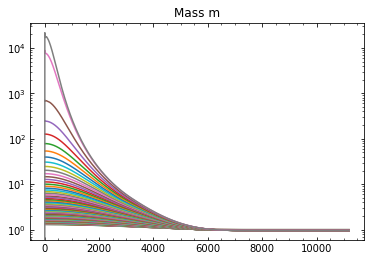

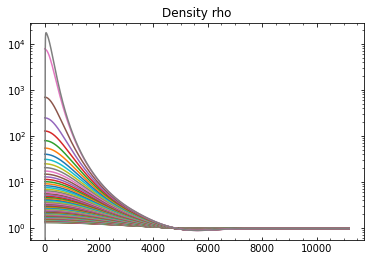

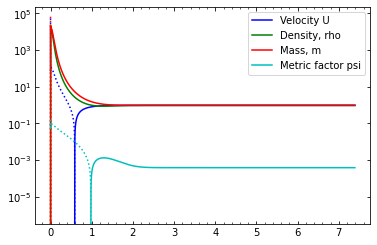

In [75]:
# Reload MS module and try a run
reload(ms_hm.MS)
from ms_hm.MS import *
amp = 0.3
(R, m, U) = gen_init(amp)
ms = MS(R, m, U, w, alpha, A, rho0,
        trace_ray=False, BH_threshold=-1, sm_sigma=20, plot_interval=200)
ms.run_steps(40000)

In [259]:
reload(ms_hm.HM)
from ms_hm.HM import *
hm = HM(ms, mOverR=0.99, sm_sigma=15)
hm.adap_run_steps(550000)
print(hm.BH_mass2())

Finding mass with amp 0.3
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
2m/R is larger than 0.99
0.481968477049894 60.14672721366863


(0.481968477049894, 60.14672721366863)

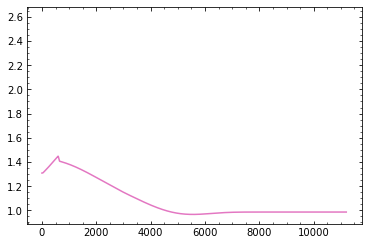

In [108]:
find_mass(0.30, is_searching_for_crit=False)

In [ ]:
# Call the find_crit function to search for the amplitude required to form a BH
find_crit(0.27, 0.30)

Finding mass with amp 0.29957632221281527
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
2m/R is larger than 0.99
0.4812869164555946 60.53504515280334


(0.4812869164555946, 60.53504515280334)

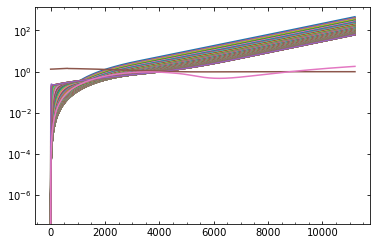

In [171]:
find_mass(0.29957632221281527, is_searching_for_crit=False)

In [14]:
find_mass(0.2728846216201781, is_searching_for_crit=True)

Finding mass with amp 0.2728846216201781
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
Warning, the time step is too small!
0.42650921473655545 0.46829034947396747


(0.42650921473655545, 0.46829034947396747)

## Simulation Run

Below is an example of all the code needed to find the critical scaling threshhold and exponent.

In [ ]:
# Find the critical point. It will be bounded between crit and lower.
(crit, lower) = find_crit()
# Find the mass of BHs at various amplitudes between lower_amp and lower_amp plus a bit.
res = critical_scaling(crit, lower_amp, lower_amp + 1e-2, 20)

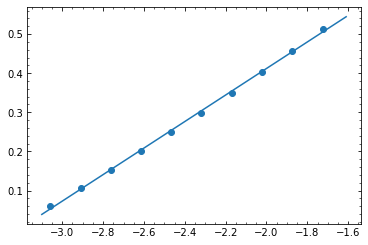

In [127]:
(a, b ) = np.polyfit(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:], deg=1)
plt.scatter(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:])
plt.plot(np.arange(-3.1,-1.6,0.01), a * np.arange(-3.1,-1.6,0.01) + b)

In [106]:
np.polyfit(np.log10(res[0][:,0] - 0.4265539636281781)[:], np.log10(res[0][:,1])[:], deg=1)

array([0.30727515, 1.00595765])